# LIVE CODING P2

1. Cargar un dataset de ejemplo con múltiples variables numéricas

In [ ]:
import numpy as np
import pandas as pd

np.random.seed(42)

n = 50

df = pd.DataFrame({
    "horas_sueno": np.random.normal(7, 1, n),
    "cafe": np.random.randint(0, 5, n),
    "pantalla": np.random.normal(6, 1.5, n),
    "ejercicio": np.random.randint(0, 90, n)
})

df["concentracion"] = (
    0.6 * df["horas_sueno"]
    - 0.4 * df["pantalla"]
    + 0.02 * df["ejercicio"]
    - 0.3 * df["cafe"]
    + np.random.normal(0, 1, n)
)

df.head()

,horas_sueno,cafe,pantalla,ejercicio,concentracion
0,7.496714,0,8.434381,72,3.217325
1,6.861736,4,7.235600,58,2.285489
2,7.647689,4,6.439589,69,0.342975
3,8.523030,0,7.344946,79,4.924471
4,6.765847,0,5.084517,2,1.080319


2. Calcule matriz de correlación con pandas y seaborn.

Heatmap

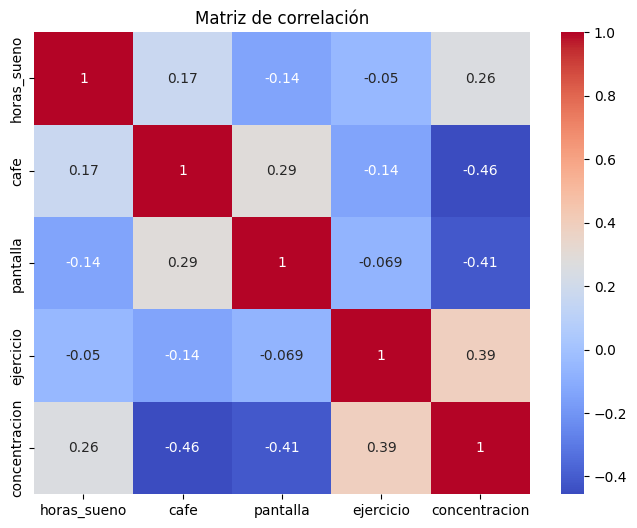

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()

Spearman con pandas

In [ ]:
corr_spearman = df.corr(method="spearman")
corr_spearman

,horas_sueno,cafe,pantalla,ejercicio,concentracion
horas_sueno,1.000000,0.179435,-0.066603,-0.037517,0.200672
cafe,0.179435,1.000000,0.341315,-0.130052,-0.465918
pantalla,-0.066603,0.341315,1.000000,-0.022530,-0.329460
ejercicio,-0.037517,-0.130052,-0.022530,1.000000,0.387904
concentracion,0.200672,-0.465918,-0.329460,0.387904,1.000000


Spearman usando scipy

In [ ]:
from scipy.stats import spearmanr

rho, p_value = spearmanr(df["ejercicio"], df["concentracion"])

rho, p_value

(np.float64(0.38790414547188734), np.float64(0.005378883741419777))

## 5. Correlación parcial

1. quitamos el efecto del sueño
2. quitamos el efecto de la pantalla
3. y miramos qué relación queda entre ejercicio y concentración

In [ ]:
#!pip install pingouin
import pingouin as pg

pg.partial_corr(
    data=df,
    x="ejercicio",
    y="concentracion",
    covar=["horas_sueno", "pantalla"]
)

,n,r,CI95%,p-val
pearson,50,0.421302,"[0.16, 0.63]",0.002863


coeficiente de correlación parcial:

r = 0.421

Interpretación:
* positivo
* magnitud moderada
* indica que, manteniendo constantes sueño y pantalla,
a mayor ejercicio, tiende a haber mayor concentración

“Incluso controlando el sueño y el uso de pantallas, el ejercicio sigue mostrando una relación positiva con la concentración.”

p-val = 0.0029

Como: p < 0.05
podemos decir:
la correlación observada es estadísticamente significativa

Resumen: El ejercicio mantiene una relación positiva con la concentración, incluso cuando se controla por otras variables relevantes, lo que refuerza su posible rol explicativo, aunque no permite afirmar causalidad.

## 6. Discute cuándo aplicar cada tipo de correlación.

| Tipo de correlación         | ¿Qué mide?                                         | ¿Cuándo usarla?                                        | Ventajas                         | Limitaciones                                           | Ejemplo                                      |
| --------------------------- | -------------------------------------------------- | ------------------------------------------------------ | -------------------------------- | ------------------------------------------------------ | -------------------------------------------- |
| **Pearson**                 | Relación **lineal** entre dos variables numéricas  | Datos continuos, relación lineal, sin outliers fuertes | Fácil de interpretar, muy usada  | No detecta relaciones no lineales, sensible a outliers | Horas de estudio vs nota                     |
| **Spearman**                | Relación **monótona** basada en rangos             | Datos no normales, ordinales, con outliers             | Robusta, funciona sin normalidad | No mide proporción del cambio                          | Ranking deportivo vs puntaje                 |
| **Parcial**                 | Relación entre dos variables **controlando otras** | Cuando hay variables confusoras                        | Aísla efectos reales             | Más compleja, requiere hipótesis                       | Ejercicio vs concentración controlando sueño |
| **Espuria** *(advertencia)* | Asociación aparente sin causalidad                 | Cuando hay una variable oculta                         | Ayuda a pensar críticamente      | Puede inducir errores si no se analiza                 | Helados vs ahogamientos                      |
| **Pearson (R²)**            | Porcentaje de variabilidad explicada               | Cuando interesa explicación/predicción                 | Intuitivo para negocio           | No implica causalidad                                  | Horas de estudio explican notas              |


## 7. Muestre gráfico de correlación temporal con plotly.

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px

np.random.seed(42)

# 1) Simular datos diarios (90 días)
n = 90
fechas = pd.date_range("2026-01-01", periods=n, freq="D")

# Serie 1: pantallas (horas)
pantalla = 6 + np.random.normal(0, 1.0, n)

# Serie 2: concentración (1–10)
# La hacemos "influida" por pantalla, pero con ruido y algo de dinámica
concentracion = 7 - 0.35 * pantalla + np.random.normal(0, 0.8, n)

df = pd.DataFrame({
    "fecha": fechas,
    "pantalla": pantalla,
    "concentracion": concentracion
})

# 2) Correlación temporal: rolling correlation (ventana de 14 días)
window = 14
df["corr_rolling"] = df["pantalla"].rolling(window).corr(df["concentracion"])

# 3) Graficar con Plotly
fig = px.line(
    df,
    x="fecha",
    y="corr_rolling",
    title=f"Correlación temporal (Spearman/Pearson rolling) - ventana {window} días"
)

fig.update_yaxes(title="Correlación (rolling)", range=[-1, 1])
fig.update_xaxes(title="Fecha")
fig.show()

“Cada punto del gráfico es la correlación calculada usando los últimos 14 días.”

“Si la línea sube, la relación se está volviendo más positiva; si baja, más negativa.”

“Si se acerca a 0, la relación se debilita o desaparece.”

### 8. Muestre gráfico de correlación espacial con datos simulados.

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px

np.random.seed(42)
n = 250

# 1) Coordenadas simuladas (como si fueran puntos en una ciudad)
x = np.random.uniform(0, 100, n)
y = np.random.uniform(0, 100, n)

# 2) Generamos una variable con patrón espacial (zonas altas y bajas)
#    Ej: concentración "más alta" cerca de (70,70) y "más baja" cerca de (30,30)
def gaussian_bump(x, y, cx, cy, s):
    return np.exp(-(((x - cx)**2 + (y - cy)**2) / (2 * s**2)))

z = (
    6
    + 3 * gaussian_bump(x, y, 70, 70, 18)    # “hotspot”
    - 2 * gaussian_bump(x, y, 30, 30, 15)    # “coldspot”
    + np.random.normal(0, 0.4, n)            # ruido
)

df = pd.DataFrame({"x": x, "y": y, "valor": z})

# 3) Gráfico espacial (puntos coloreados por valor)
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="valor",
    title="Mapa simulado: patrón espacial (zonas altas y bajas)",
    labels={"x": "Coordenada X", "y": "Coordenada Y", "valor": "Valor"}
)
fig.update_traces(marker=dict(size=9, opacity=0.85))
fig.show()